ASL, 07.03.22

# Introduction

As we've learned, deep neural networks provide (at least partly) hierarchical representations of data, tailored for a given task. 

<img src="https://upload.wikimedia.org/wikipedia/en/8/83/VGG_neural_network.png">

At the end of a high-performance deep neural network, i.e. in the later hidden layers, you'll find a representation for each data instance that makes the task (relatively) easy to solve. 

An idea that can be quite useful in a wide variety of tasks is to _extract_ these representations and use them in other ML models. This is one easy way to combine information extracted by a deep neural network with other useful information for the task at hand. 

We'll use this idea in this notebook by extracting vector representations from the last hidden layer of a trained CNN, and use them to for training other ML models.

We'll do that by using so-called PyTorch **hooks**.

## Hooks in PyTorch

Remember that neural networks are **computational graphs**

![](https://docs.chainer.org/en/latest/_images/googlenet.png)<br>
<center><small>Illustration from <a href="https://docs.chainer.org/en/stable/">https://docs.chainer.org/en/stable/</a> </small></center>

- Hooks are functions injected into these computational graphs by attaching them to tensors or to modules (network layers)
- This allows us to access, and potentially modify, gradients associated with tensors, and the inputs and outputs of layers (modules) as they flow through the computational graphs
- We can attach backward and forward hooks to modules: triggered during backward and forward calculations, respectively.

> In this notebook, we'll attach a hook to the final linear layer of the model to grab the activations before they are passed to the final classification layers. These activations will be a task-specific representation of the data. 

You can find discussion of hooks in the fastai book, [Chapter 18](https://github.com/fastai/fastbook/blob/master/18_CAM.ipynb). 

The PyTorch docs has a description of hooks here: https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks. See also the Paperspace blog post: https://blog.paperspace.com/pytorch-hooks-gradient-clipping-debugging/. Here's a video tutorial that explains hooks in quite some detail: https://www.youtube.com/watch?v=syLFCVYua6Q. 

# Setup

In [80]:
%matplotlib inline
import pandas as pd
import numpy as np
from pathlib import Path
import pandas as pd

In [81]:
# If Jedi's not working
%config Completer.use_jedi = False

In [82]:
NB_DIR = Path.cwd()

# Point this to where you stored the MOESM data:
DATA = NB_DIR/'data'/'drug'
RAW_DATA = DATA/'raw'
# Path to image data as defined earlier
IMGDATA = Path('/data2/drugdiscovery/MOESM/molimages/')

In [83]:
NB_DIR = Path.cwd()
LOCALDATA = NB_DIR/'data'/'drug'/'interim'

In [84]:
from fastai.vision.all import *

# Load data

In [85]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    name = data.stem
    
    df = pd.read_csv(data)
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    df = df[['CID', 'SMILES', 'Image', 'Activity']]
    
    return df, name

We remember that we had 7 activity datasets:

In [86]:
# Datasets available:
data = sorted(list(RAW_DATA.glob('CHEM*cl.csv')))
data

[Path('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL1978_cl.csv'),
 Path('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL205_cl.csv'),
 Path('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL218_cl.csv'),
 Path('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL219_cl.csv'),
 Path('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL240_cl.csv'),
 Path('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL244_cl.csv'),
 Path('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL301_cl.csv')]

...and that we've generated images of the molecules:

In [87]:
IMGDATA.ls()

(#3) [Path('/data2/drugdiscovery/MOESM/molimages/CHEMBL205_cl'),Path('/data2/drugdiscovery/MOESM/molimages/CHEMBL1978_cl'),Path('/data2/drugdiscovery/MOESM/molimages/CHEMBL218_cl')]

We'll use the **CHEMBL1978** data set in this notebook, as it's one of the smaller ones (and therefore quicker to train models on and to extract features from):

In [88]:
ds = data[0]
ds

Path('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/raw/CHEMBL1978_cl.csv')

In [89]:
df, name = get_df(ds)

In [90]:
df.head()

,CID,SMILES,Image,Activity
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,CHEMBL1454842.png,1
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,CHEMBL192155.png,1
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CID       6831 non-null   object
 1   SMILES    6831 non-null   object
 2   Image     6831 non-null   object
 3   Activity  6831 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 213.6+ KB


In [92]:
df['Activity'].value_counts()

0    6210
1     621
Name: Activity, dtype: int64

## Create train-val-split and oversample train

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df

In [95]:
df = val_cols_and_oversample(df)

In [96]:
df.head()

,CID,SMILES,Image,Activity,is_valid
0,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1,False
1,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1,False
2,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1,False
3,CHEMBL1957218,s1cc(nc1-c1ccncc1C)-c1cccnc1,CHEMBL1957218.png,1,False
4,CHEMBL1957223,s1cc(nc1-c1cccnc1)-c1ccc(OC)nc1,CHEMBL1957223.png,1,False


In [97]:
df['Activity'].value_counts()

0    6210
1    4815
Name: Activity, dtype: int64

# Create a dataloader

In [98]:
bs=64

In [99]:
batch_tfms = [Rotate(max_deg=25, pad_mode='border'), 
              Normalize.from_stats(*imagenet_stats)]

In [100]:
datablock = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=ColSplitter('is_valid'),
    item_tfms=None,
    batch_tfms=batch_tfms
    )

In [101]:
dls = datablock.dataloaders(df, bs=bs, shuffle_train=True)

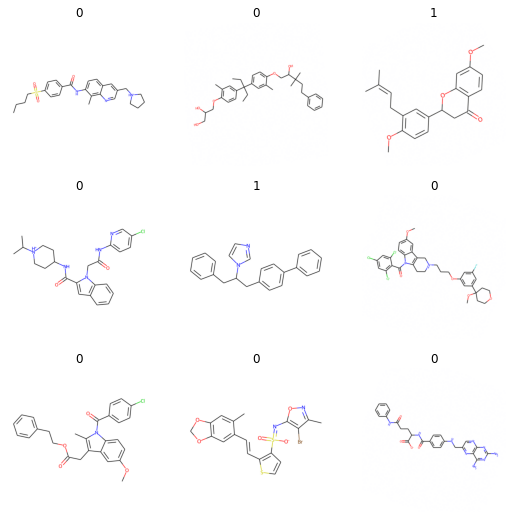

In [102]:
dls.show_batch()

# Train a CNN

In [103]:
from utils import plot_metrics

We use a pretrained resnet18 model as before, only adding a custom "head" to the model that outputs 128 features (to have fewer activations in the final hidden layer):

In [104]:
resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [105]:
custom_head = create_head(nf=512, n_out=2, lin_ftrs=[128], concat_pool=True)

In [107]:
custom_head

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=128, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=128, out_features=2, bias=False)
)

In [108]:
learn = cnn_learner(dls,                             
                arch=resnet18, pretrained=True,  
                custom_head=custom_head,
                wd=2e-4, ps=0.8,                    
                metrics=[accuracy,                  
                         F1Score(), 
                         Precision(), 
                         Recall(), 
                         RocAucBinary(), 
                         MatthewsCorrCoef()],
                cbs=[ShowGraphCallback()])

In [110]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

The below training takes a while. We can rather load the results of a previous run:

In [111]:
learn = learn.load('chembl1978-model-test-hooks')

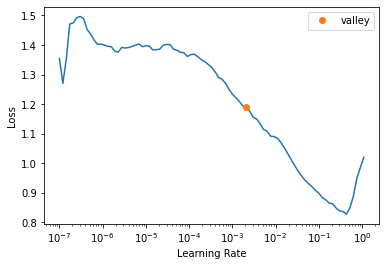

In [30]:
lr = learn.lr_find()

In [31]:
lr.valley

0.0020892962347716093

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.598264,0.402193,0.822600,0.476684,0.325472,0.890323,0.930682,0.469560,00:37
1,0.363147,0.236798,0.901054,0.626932,0.476510,0.916129,0.962038,0.617380,00:37
2,0.252808,0.162805,0.936183,0.719794,0.598291,0.903226,0.971884,0.703990,00:37
3,0.194745,0.143020,0.950234,0.773333,0.659091,0.935484,0.978348,0.760774,00:37
4,0.162597,0.112273,0.957260,0.792023,0.709184,0.896774,0.981343,0.775143,00:38
5,0.142201,0.133590,0.954333,0.786885,0.682464,0.929032,0.979191,0.773356,00:37
6,0.134176,0.111604,0.964286,0.818991,0.758242,0.890323,0.978389,0.802493,00:37
7,0.113144,0.114717,0.962529,0.816092,0.735751,0.916129,0.979137,0.801437,00:37
8,0.109072,0.104854,0.970141,0.848665,0.785714,0.922581,0.982195,0.835521,00:37
9,0.092331,0.118486,0.964871,0.826590,0.748691,0.922581,0.983329,0.812732,00:37


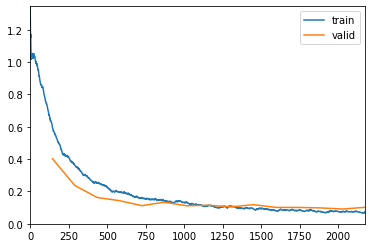

In [103]:
learn.fit_one_cycle(15, slice(lr.valley))

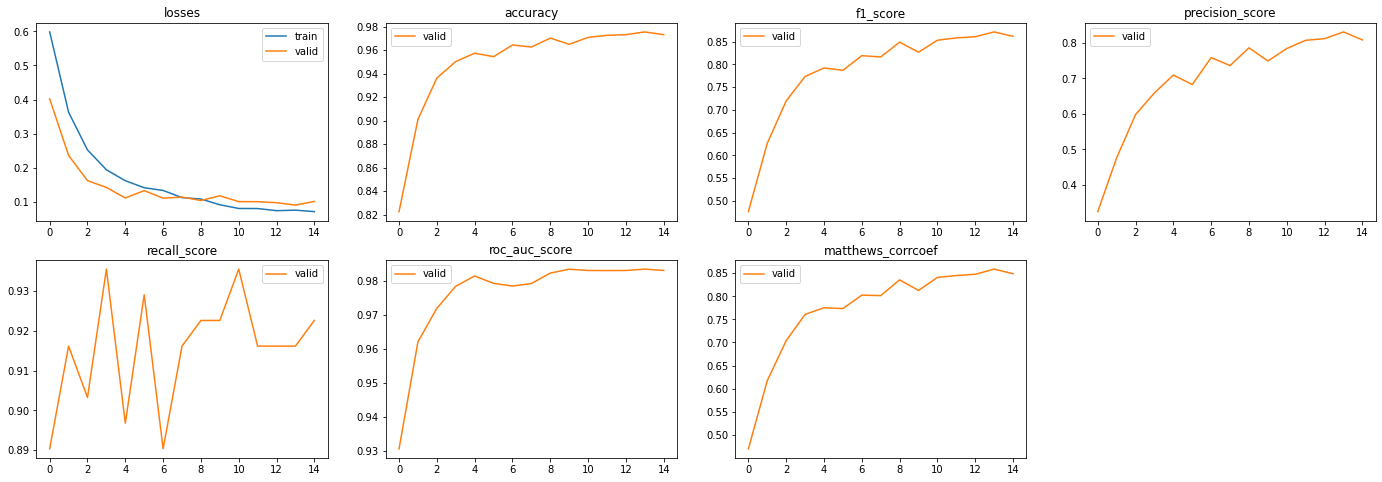

In [104]:
learn.recorder.plot_metrics()

In [105]:
#learn.save('chembl1978-model-test-hooks')

Path('models/chembl1978-model-test-hooks.pth')

### Evaluate

In [112]:
interp = ClassificationInterpretation.from_learner(learn)

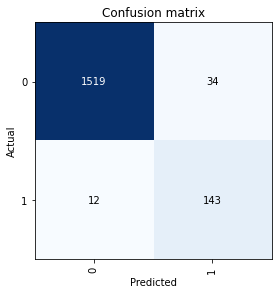

In [113]:
interp.plot_confusion_matrix()

# Save activations 

from second final layer. To be used to train a different ML model.

We need to register a **forward hook** at the layer we want to save activations from:

In [114]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [116]:
learn.model[-1][-5]

Linear(in_features=1024, out_features=128, bias=False)

In [117]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

Create the df again, this time with no oversampling (as that's not necessary).

In [118]:
df, name = get_df(ds)

df_nodupl = val_cols_and_oversample(df, oversample=False)

No data augmentation:

In [119]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

We can feed one image at a time throught the model to get the activations

In [120]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [121]:
test_df = test_dls.items.reset_index()

In [122]:
test_df.head()

,index,CID,SMILES,Image,Activity,is_valid
0,4949,CHEMBL30885,Fc1cc(ccc1)-c1nc(NCCC[NH3+])c2c(nccc2)c1,CHEMBL30885.png,0,False
1,3075,CHEMBL2304158,O1C(C(=O)NCC)C(O)C(O)C1n1c2nc(nc(N)c2nc1)\C=C\CCCc1ccccc1,CHEMBL2304158.png,0,True
2,5402,CHEMBL1784216,Clc1ccccc1CNC(=O)N1CCN(CC1)c1nc(C(F)(F)F)c(cc1C#N)C(OCC)=O,CHEMBL1784216.png,0,False
3,6827,CHEMBL2047477,[N+]=1(c2c3c(cccc3ccc2)C=1\C=C\C=C\1/N(c2c3c/1cccc3ccc2)CC)CC,CHEMBL2047477.png,0,False
4,1614,CHEMBL161426,S(=O)(=O)(Nc1ccccc1C(=O)[O-])c1cc([N+](=O)[O-])c(N\N=C(\S)/NCCc2c3c([nH]c2)cccc3)cc1,CHEMBL161426.png,0,False


Each element of the dataset consists of an image (a `PILImage`) and a category (the corresponding activity label):

In [123]:
test_dls.dataset[0]

(PILImage mode=RGB size=500x500, TensorCategory(0))

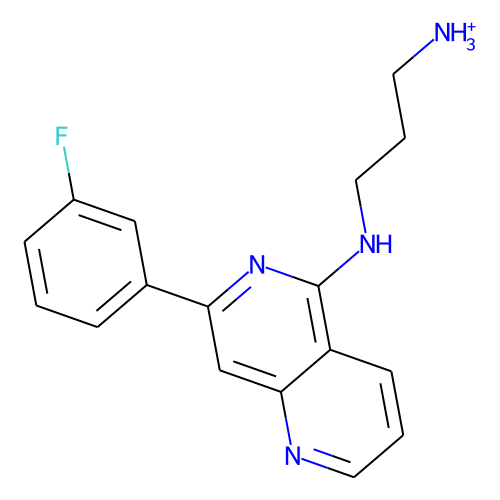

In [124]:
test_dls.dataset[0][0]

In [126]:
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [128]:
def get_activations(CID):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    data = get_data(CID)
    img = data[0]
    
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]

    return list(acts)

The below computation takes a while.. We can rather load results computed earlier:

In [129]:
df_acts = pd.read_csv('data/chembl1978_cnn_activations.csv')

In [46]:
#%%time
#%%capture
#df_nodupl['activations'] = df_nodupl.CID.apply(get_activations)

Now we've stored activations for each image:

In [122]:
#df_nodupl.head()

We split the activations to have one column for each, as they will be treated as separate features later:

In [123]:
df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [124]:
df_acts.drop('activations', axis=1, inplace=True)

Here's the result:

In [130]:
df_acts.head()

,CID,SMILES,Image,Activity,is_valid,act_0,act_1,act_2,act_3,act_4,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,CHEMBL1454842.png,1,True,-0.820927,1.599694,1.260729,3.748067,0.037893,...,-1.790191,7.012941,-1.325754,-1.521657,3.999487,2.921258,1.722122,4.411922,-0.823264,0.042515
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,CHEMBL1939366.png,1,False,2.635171,2.416980,1.853653,5.227939,-2.236960,...,-1.920773,9.826849,-4.740241,-1.105941,0.104540,4.031108,0.983188,9.893621,-3.281317,-0.921214
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,CHEMBL192155.png,1,True,4.975932,-6.964100,4.826443,4.821192,2.235748,...,1.653817,7.786195,-1.330809,-0.391013,-0.528322,-1.384658,-10.663100,2.034417,-0.073622,1.652125
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL517816.png,1,False,-0.519295,-2.976304,-7.294024,7.510887,1.606539,...,-8.291656,2.217098,-3.147825,-0.987249,0.098486,0.057770,-3.116627,9.228285,0.096559,3.765280
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,CHEMBL523973.png,1,False,-1.554784,0.365316,-7.547758,6.179128,2.069743,...,-8.472736,5.286431,-0.829980,-0.769926,-2.355638,-3.735748,-4.579318,9.686918,-0.851172,4.186673


In [131]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 133 entries, CID to act_127
dtypes: bool(1), float64(128), int64(1), object(3)
memory usage: 6.9+ MB


In [47]:
#df_acts.to_csv('data/chembl1978_with_cnn_activations.csv', index=None)

# Add molecular fingerprints

When training the random forest below, we'll compare the results obtained by using _molecular fingerprints_ as features describing molecules. See the notebook `1.0-get_molecular_fingerprints_and_images.ipynb` for the code to generate fingerprints.

In [132]:
df_ecfp = pd.read_csv(LOCALDATA/'CHEMBL1978_cl_ecfp_1024.csv')

In [133]:
df_ecfp.head()

,CID,SMILES,Activity,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,ECFP4_1015,ECFP4_1016,ECFP4_1017,ECFP4_1018,ECFP4_1019,ECFP4_1020,ECFP4_1021,ECFP4_1022,ECFP4_1023,ECFP4_1024
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
df_ecfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 1027 entries, CID to ECFP4_1024
dtypes: int64(1025), object(2)
memory usage: 53.5+ MB


In [135]:
df_acts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6831 entries, 0 to 6830
Columns: 133 entries, CID to act_127
dtypes: bool(1), float64(128), int64(1), object(3)
memory usage: 6.9+ MB


In [136]:
df = df_ecfp.merge(df_acts, on='CID')

In [137]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,-1.790191,7.012941,-1.325754,-1.521657,3.999487,2.921258,1.722122,4.411922,-0.823264,0.042515
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,-1.920773,9.826849,-4.740241,-1.105941,0.104540,4.031108,0.983188,9.893621,-3.281317,-0.921214
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,1.653817,7.786195,-1.330809,-0.391013,-0.528322,-1.384658,-10.663100,2.034417,-0.073622,1.652125
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-8.291656,2.217098,-3.147825,-0.987249,0.098486,0.057770,-3.116627,9.228285,0.096559,3.765280
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-8.472736,5.286431,-0.829980,-0.769926,-2.355638,-3.735748,-4.579318,9.686918,-0.851172,4.186673


In [138]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [139]:
df.head()

,CID,SMILES_x,Activity_x,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
0,CHEMBL1454842,s1nc(nc1-c1ccncc1)-c1ccncc1,1,0,0,0,0,0,0,0,...,-1.790191,7.012941,-1.325754,-1.521657,3.999487,2.921258,1.722122,4.411922,-0.823264,0.042515
1,CHEMBL1939366,s1nc(nc1-c1cccnc1)-c1cccnc1,1,0,0,0,0,0,0,0,...,-1.920773,9.826849,-4.740241,-1.105941,0.104540,4.031108,0.983188,9.893621,-3.281317,-0.921214
2,CHEMBL192155,s1cncc1\C=C\1/CCc2cc(OC)ccc/12,1,0,0,0,0,0,0,0,...,1.653817,7.786195,-1.330809,-0.391013,-0.528322,-1.384658,-10.663100,2.034417,-0.073622,1.652125
3,CHEMBL517816,s1cccc1CN(n1ncnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-8.291656,2.217098,-3.147825,-0.987249,0.098486,0.057770,-3.116627,9.228285,0.096559,3.765280
4,CHEMBL523973,s1cccc1CN(n1ccnc1)Cc1ccc(cc1)C(C)(C)C,1,0,0,0,0,0,0,0,...,-8.472736,5.286431,-0.829980,-0.769926,-2.355638,-3.735748,-4.579318,9.686918,-0.851172,4.186673


In [140]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

Save the dataframe:

In [141]:
LOCALDATA

Path('/home/ubuntu/Dropbox/medGPU-alex/DAT255/DAT255-repo/CNN_feature_extraction/nbs/data/drug/interim')

In [ ]:
#df.to_csv(LOCALDATA/'chembl1978-data-with-ecfp-activations.csv', index=None)

# Train machine learning models on extracted features

### Split the data

We use the validation data from the CNN model as test data (as it's unseen by the CNN model during training).

In [142]:
train = df.loc[df.is_valid==False]
test = df.loc[df.is_valid==True]

In [143]:
X_train, y_train = train.drop(["CID", "SMILES", "Activity", "Image"], axis=1), train["Activity"]

In [144]:
X_test, y_test = test.drop(["CID", "SMILES", "Activity", "Image"], axis=1), test["Activity"]

In [145]:
X_train.head()

,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,ECFP4_9,ECFP4_10,...,act_118,act_119,act_120,act_121,act_122,act_123,act_124,act_125,act_126,act_127
1,0,0,0,0,0,0,0,0,0,0,...,-1.920773,9.826849,-4.740241,-1.105941,0.104540,4.031108,0.983188,9.893621,-3.281317,-0.921214
3,0,0,0,0,0,0,0,0,0,0,...,-8.291656,2.217098,-3.147825,-0.987249,0.098486,0.057770,-3.116627,9.228285,0.096559,3.765280
4,0,0,0,0,0,0,0,0,0,0,...,-8.472736,5.286431,-0.829980,-0.769926,-2.355638,-3.735748,-4.579318,9.686918,-0.851172,4.186673
5,0,0,0,0,0,0,0,0,0,0,...,-0.276224,9.250120,-0.476589,-1.528430,0.171444,-2.985032,-2.574457,5.205038,-1.652707,-2.909199
8,0,0,0,0,0,0,0,0,0,0,...,-0.986709,6.246221,-4.863071,-3.208438,-5.464539,2.170959,-4.437507,4.628281,1.158761,-0.845360


In [146]:
y_train.head()

1    1
3    1
4    1
5    1
8    1
Name: Activity, dtype: int64

### Logistic Regression and Random forest

In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [148]:
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score, 
matthews_corrcoef, precision_score, f1_score)

In [149]:
def train_lr(X_train, X_test, y_train, y_test, features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Must scale the data for the linear logreg model:
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)
    
    
    lr = LogisticRegression(max_iter=500)
  
    lr.fit(X_train_std, y_train)
    
    y_pred = lr.predict(X_test_std)
    y_pred_prob = lr.predict_proba(X_test_std)
    
    temp=[]
    for j in range(len(y_pred_prob)):
    	temp.append(y_pred_prob[j][1])
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    Recall=recall_score(y_test, y_pred,pos_label=1)
    Precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)
    
    print(f"AUC: {auc.round(5)}, Acc: {acc2.round(5)}, MCC: {mcc.round(5)}")
    print(f"Recall: {Recall.round(5)}, Precision: {Precision.round(5)}, F1_score: {F1_score.round(5)}")

    return auc,acc2,mcc,Recall,Precision,F1_score, lr

In [150]:
def train_rf(X_train, X_test, y_train, y_test, n_estimators=100, 
             criterion='gini', max_features='log2', features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Following the settings in the paper, `RF_tune.py`
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, min_samples_split=2, 
                                    max_features=max_features, max_leaf_nodes=None, 
                                    bootstrap=False,oob_score=False, n_jobs=-1, 
                                    random_state=100)
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    y_pred_prob = rf.predict_proba(X_test)
    
    temp=[]
    for j in range(len(y_pred_prob)):
    	temp.append(y_pred_prob[j][1])
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    Recall=recall_score(y_test, y_pred,pos_label=1)
    Precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)
    
    print(f"AUC: {auc.round(5)}, Acc: {acc2.round(5)}, MCC: {mcc.round(5)}")
    print(f"Recall: {Recall.round(5)}, Precision: {Precision.round(5)}, F1_score: {F1_score.round(5)}")

    return auc,acc2,mcc,Recall,Precision,F1_score, rf

**Logistic regression:**

In [151]:
_ = train_lr(X_train, X_test, y_train, y_test, features='ECFP')

Training on 1024 features

AUC: 0.98444, Acc: 0.97541, MCC: 0.85188
Recall: 0.87097, Precision: 0.85987, F1_score: 0.86538


In [152]:
_ = train_lr(X_train, X_test, y_train, y_test, features='act_')

Training on 128 features

AUC: 0.97396, Acc: 0.96194, MCC: 0.76241
Recall: 0.75484, Precision: 0.8125, F1_score: 0.78261


In [153]:
_ = train_lr(X_train, X_test, y_train, y_test, features='all')

Training on all 1153 ECFP and CNN features

AUC: 0.98535, Acc: 0.97541, MCC: 0.85188
Recall: 0.87097, Precision: 0.85987, F1_score: 0.86538


**Random forest:**

In [154]:
_ = train_rf(X_train, X_test, y_train, y_test, features='ECFP')

Training on 1024 features

AUC: 0.99229, Acc: 0.97951, MCC: 0.87051
Recall: 0.81935, Precision: 0.94776, F1_score: 0.87889


In [155]:
_ = train_rf(X_train, X_test, y_train, y_test, features='act_')

Training on 128 features

AUC: 0.97899, Acc: 0.97365, MCC: 0.83127
Recall: 0.76774, Precision: 0.92969, F1_score: 0.84099


In [156]:
_ = train_rf(X_train, X_test, y_train, y_test, features='all')

Training on all 1153 ECFP and CNN features

AUC: 0.98155, Acc: 0.97073, MCC: 0.81167
Recall: 0.74839, Precision: 0.91339, F1_score: 0.8227
